## MeanFlow 
Kaiming He and others have released a paper on flow based model where they are modeling average velocity instead of instantaneous velocity as we have seen in the previous flow implementation.

In [1]:
# Looad required libraries 

import torch 
import numpy as np
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

## Foundations - Gradients
Paper speaks about Jacobian vector product, while I would like you to refer to some good resources on internet for what directional derivatives means, I will still do my job here using a simple example ( u can watch many online videos with nice visualizations), consider an example $f(x)=x^2y$

Now the partial derivate of this function basically gives

$$
\nabla f = \begin{bmatrix} \frac{\partial f}{\partial x} \\ \frac{\partial f}{\partial y} \end{bmatrix}
$$

$$
\nabla f = \begin{bmatrix} 2xy \\ x^2 \end{bmatrix}
$$

Now the gradient is like a vector field as shown below




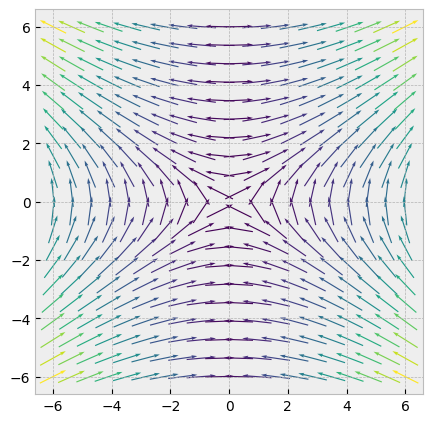

In [2]:
x = np.linspace(-6, 6, 20)
y = np.linspace(-6, 6, 20)
X, Y = np.meshgrid(x, y)

# Calculate vector components
# f(x, y) = [2xy, x^2]
U = 2*X*Y  # x-component: 2xy
V = X**2  # y-component: x^2
magnitude = np.sqrt(U**2 + V**2)

U_norm = U/magnitude
V_norm = V/magnitude

# Create the plot
plt.figure(figsize=(5, 5))

# Plot the vector field with color based on magnitude
plt.quiver(X, Y, U_norm, V_norm, magnitude, cmap='viridis', 
           pivot='mid', angles='xy', scale_units='xy', scale=1)
plt.show()

## Foundations Directional derivatives 
A small nudge in x and in y basically gives the rate of change in the function f(x,y), this is often represented in partial derivatives as [$\frac{df}{dx}$, $\frac{df}{dy}$] (shown above). Now from any point on the function there can be several unit vectors pointing in different directions, lets call this vector $\vec{v}$ and represented as $[a, b]$. Now as we move along this vector direction, a small nudge in x direction means its equivalent to $a*\nabla x f$ and small nudge in y direction means its equivalent to $b*\nabla y f$

the directional derivative is simply the dot product.
$$
D_{\vec{v}}f = \frac{df}{ds} = a \frac{\partial f}{\partial x} + b \frac{\partial f}{\partial y} = \nabla f \cdot \vec{v}
$$

Now lets calculate directional derivate of a function $f(x,y) = x^2y$ at (1,2) in the direction of (-1/$\sqrt{5}$, 2/$\sqrt{5}$)

$$
df = -1/\sqrt{5} * \frac{\partial f}{\partial x} + 2\sqrt{5} * \frac{\partial f}{\partial y}
$$

$$
\frac{\partial f}{\partial x} = 2xy = 2*1*2 = 4
$$

$$
\frac{\partial f}{\partial y} = x^2 = 1
$$

$$
df = \frac{-1}{\sqrt{5}} * 4 + \frac{2}{\sqrt{5}} * 1 = \frac{-2}{\sqrt{5}}
$$

In [3]:
-2/torch.sqrt(torch.tensor(5))

tensor(-0.8944)

## Jacobian vector product 
In pytorch calculating this directional derivative is called Jacobian vector product. we will do the above example using pytorch now.

In [4]:
point = torch.tensor([1.0, 2.0], requires_grad=True)
x, y = point[0], point[1]

# Define direction vector (not necessarily unit vector initially)
direction = torch.tensor([-1.0, 2.0])

# Normalize to make it a unit vector for proper directional derivative
unit_direction = direction / torch.norm(direction)
unit_direction


tensor([-0.4472,  0.8944])

In [5]:
def func_vector_input(inputs):
    x, y = inputs[0], inputs[1]
    return x**2 * y

In [6]:
func_output, directional_deriv_jvp = torch.autograd.functional.jvp(
    func_vector_input, 
    (point,), 
    (unit_direction,)
)
func_output, directional_deriv_jvp

(tensor(2.), tensor(-0.8944))

> the second term is the directional derivative of the function. 

> first term in the function output

we can see that both are same. we will now learn why this is important and how it is used in the paper.

## Paper 

we will start with instantenous change in velocity

$$
\frac{d}{dt}z_{t} = v(z_{t}, t)
$$

and 

$$
z_{t} = (1-t)x_{0} + t x_{1}
$$

$$
\frac{d}{dt}z_{t} = x_{1} - x_{0}
$$

here $x_{1}$ is $p_{data}$ and $x_{0}$ is $p_{noise}$ 


### MeanFlow 
instead of looking at instantenous change of velocity, in the paper they look at average velocity within a time period r to t. this is given as 

$$
u(z_{t}, r, t) = \frac{1}{t-r} \int_{r}^{t} v(z_{t}, \tau) d\tau
$$

becomes 
$$
(t-r) u(z_{t}, r, t) = \int_{r}^{t} v(z_{t}, \tau) d\tau
$$

differentiating both sides by dt 

$$
\frac{d}{dt} (t-r) u(z_{t}, r, t) = \frac{d}{dt} \int_{r}^{t} v(z_{t}, \tau) d\tau 
$$

$$
 u(z_{t}, r, t) + (t-r) \frac{d}{dt} u(z_{t}, r, t) = v(z_{t}, t)
$$

moving things from left to right, we have average velocity equals to instant velocity and time derivative.
$$
u(z_{t}, r, t) = v(z_{t}, t) - (t-r) \frac{d}{dt} u(z_{t}, r, t) 
$$

### computing time derivative 
using partial derivatives we can expand

$$
\frac{d}{dt} u(z_{t}, r, t)  = \frac{dz_{t}}{dt} \partial_{z}u + \frac{dr}{dt} \partial_{r}u + \frac{dt}{dt} \partial_{t}u
$$

this looks like dot product ($\frac{dz_{t}}{dt}$, $\frac{r}{dt}$, $\frac{dt}{dt}$) and ($\partial_{z}u$, $\partial_{r}u$, $\partial_{t}u$). ($\frac{dz_{t}}{dt}$, $\frac{r}{dt}$, $\frac{dt}{dt}$)  can be further be simplied as

$$
\frac{dz_{t}}{dt} = v(z_{t}, t)
$$

$$
 \frac{r}{dt} = 0
$$

$$
\frac{t}{dt} = 1
$$

so (v, 0, 1)

so the dot product between ($\partial_{z}u$, $\partial_{r}u$, $\partial_{t}u$) lets call this $\vec{J}$ and  ($\frac{dz_{t}}{dt}$ and (v($z_{t}$, t), 0, 1) $\vec{Q}$. 


so finally $u(z_{t}, r, t)$ becomes 

$$
u(z_{t}, r, t) = v(z_{t}, t) - (t-r) (\vec{J}.\vec{Q})
$$


$\vec{J}.\vec{Q}$ is obtained in pytorch using `torch.autograd.functional.jvp` which we will see in the next sections. 


Note that when t = r the average velocity just comes instantaneous velocity.





## MNIST

In [7]:
# Load MNIST data 

# Load MNIST data and resize it to 64x64
def load_mnist(bs=64):
    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('data/', train=True, download=True,
                                    transform=torchvision.transforms.Compose([
                                        torchvision.transforms.Pad(2),
                                        torchvision.transforms.ToTensor(),
                                        torchvision.transforms.Normalize(0.5, 0.5),
                                    ])),
        batch_size=bs, shuffle=True)

    val_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('data/', train=False, download=True,
                                    transform=torchvision.transforms.Compose([
                                        torchvision.transforms.Pad(2),
                                        torchvision.transforms.ToTensor(),
                                        torchvision.transforms.Normalize(0.5, 0.5),
                                    ])),
        batch_size=bs, shuffle=False)
    return train_loader, val_loader

train_loader, val_loader = load_mnist(bs=64)

print(len(train_loader), len(val_loader))

imgs, labels = next(iter(val_loader))
imgs.shape

938 157


torch.Size([64, 1, 32, 32])

In [8]:
imgs, labels = next(iter(train_loader))
imgs.shape, labels.shape

(torch.Size([64, 1, 32, 32]), torch.Size([64]))

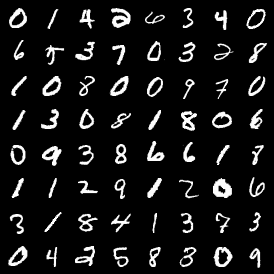

In [9]:
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(imgs, nrow=8, normalize=True))

In [10]:
time = torch.distributions.Normal(-0.4, 1)
rt = time.sample((10,2)).sort(dim=1).values
rt = torch.sigmoid(rt)
rt



tensor([[0.1793, 0.2115],
        [0.1759, 0.8306],
        [0.2381, 0.6455],
        [0.1247, 0.1757],
        [0.2990, 0.3690],
        [0.5128, 0.7660],
        [0.4621, 0.8029],
        [0.2596, 0.5610],
        [0.3143, 0.3730],
        [0.2963, 0.7248]])

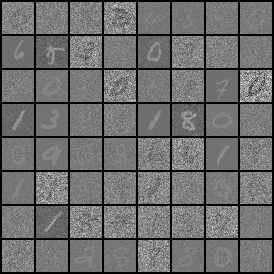

In [11]:
bs = imgs.shape[0]
rt = time.sample((bs,2)).sort(dim=1).values
noise = torch.randn_like(imgs)
t = rt[:, 1].unsqueeze(1).unsqueeze(1).unsqueeze(1)
xt = (1-t)*(noise) + t*imgs
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(xt, nrow=8, normalize=True))


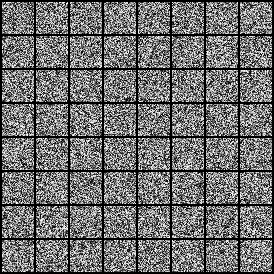

In [12]:
target = imgs - noise
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(target, nrow=8, normalize=False))

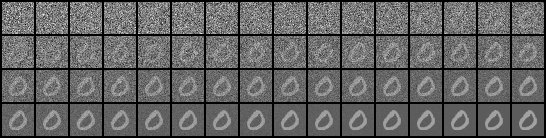

In [13]:
# lets also look how same image looks at different timesteps
simgs = imgs[0].unsqueeze(0).repeat(bs, 1, 1, 1)
bs = simgs.shape[0]
t = torch.linspace(0, 1, bs).unsqueeze(1).unsqueeze(1).unsqueeze(1)
noise = torch.randn_like(simgs)
sxt = (1-t)*noise + t*simgs
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(sxt, nrow=16, normalize=True))

## Network
we have two conditionals here r and t. in the paper they mentioned we can condition this as 
- r, t separately 
- t, t-r 
- t, r, t-r 
- t-r only 

> t, t-r got the best results. 


for imageNet they used DiT architecture but for CIFAR-10 they used U-Net. we cannot use U-Net from diffusers directly as it takes only one time conditioning and here we have to condition on two variables t and t-r. In the paper, they took positional embeddings of the time variables and then concatenated them before sending to the architecture. 

I have made these changes to diffusers UNet 2D using `multiple_time_embeddings`
- for both t and t-r get positional embeddings. 
- use linear layers to calculate their embeddings. 
- concat both of these.

In [14]:
from mean_flow.unet2d import UNet2DModel

device = "cuda"

model = UNet2DModel(
    sample_size=32,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(64, 128, 256, 512),
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
    resnet_time_scale_shift="mean_flow"
)
model.to(device)
print("model loaded")

/home/prakashjay/genai/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


model loaded


In [15]:
model

UNet2DModel(
  (conv_in): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_delta_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (time_delta_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=256, out_features=32, bias=True)
          (delta_emb_proj): Linear(in_features=256, out_features=32, bias=True)
          (norm2): GroupNorm

In [16]:
from diffusers.models.attention_processor import AttnProcessor


for blocks in model.down_blocks:
    if hasattr(blocks, "attentions"):
        for attn in blocks.attentions:
            attn.processor = AttnProcessor()

for blocks in model.up_blocks:
    if hasattr(blocks, "attentions"):
        for attn in blocks.attentions:
            attn.processor = AttnProcessor()

model.mid_block.attentions[0].processor = AttnProcessor()
print("processor set")

processor set


In [17]:
def load_model(device, channels=1):
    model = UNet2DModel(
        sample_size=32,
        in_channels=channels,
        out_channels=channels,
        layers_per_block=2,
        block_out_channels=(64, 128, 256, 512),
        down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "DownBlock2D"),
        up_block_types=("UpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
        resnet_time_scale_shift="mean_flow"
    )
    model.to(device)

    for blocks in model.down_blocks:
        if hasattr(blocks, "attentions"):
            for attn in blocks.attentions:
                attn.processor = AttnProcessor()

    for blocks in model.up_blocks:
        if hasattr(blocks, "attentions"):
            for attn in blocks.attentions:
                attn.processor = AttnProcessor()

    model.mid_block.attentions[0].processor = AttnProcessor()
    return model

In [18]:
count = 0
for name, param in model.named_parameters():
    count += param.numel()
count # this is a ~16 million parameters model


57972097

In [19]:
out = model(xt.to(device), (rt[:, 0]*1000).to(device), ((rt[:, 1]-rt[:, 0])*1000).to(device))["sample"]
out.shape, torch.nn.functional.mse_loss(out, target.to(device))

(torch.Size([64, 1, 32, 32]),
 tensor(1.9072, device='cuda:0', grad_fn=<MseLossBackward0>))

In [20]:
torch.tensor([0]).repeat(xt.shape[0], 1).to(device).shape

torch.Size([64, 1])

In [21]:
from functools import partial
partial_model = partial(model, return_dict=False)

In [22]:
u, dudt = torch.autograd.functional.jvp(
    partial_model, 
    (xt.to(device), (rt[:, 0]*1000).to(device), (rt[:, 1]*1000).to(device)), 
    (target.to(device), torch.zeros(xt.shape[0]).to(device), torch.ones(xt.shape[0]).to(device))
)
u[0].shape, dudt[0].shape

(torch.Size([64, 1, 32, 32]), torch.Size([64, 1, 32, 32]))

In [23]:
u_tgt = target.to(device) - (rt[:, 1] - rt[:, 0]).unsqueeze(1).unsqueeze(1).unsqueeze(1).to(device)*dudt[0]
error = torch.nn.functional.mse_loss(u[0], u_tgt.detach())
error
# calculate the gradient of the error with respect to the model parameters

tensor(2.6410, device='cuda:0')

In [24]:
## Pseudo Huber loss 

# def adaptive_weighted_short(input, target, p=0.5, c=1e-3):
#     mse = torch.nn.functional.mse_loss(input, target, reduction='none')
#     return (mse / (mse + c)**p).mean()


def adaptive_l2_loss(error, gamma=0.5, c=1e-3):
    """
    Adaptive L2 loss: sg(w) * ||Δ||_2^2, where w = 1 / (||Δ||^2 + c)^p, p = 1 - γ
    Args:
        error: Tensor of shape (B, C, W, H)
        gamma: Power used in original ||Δ||^{2γ} loss
        c: Small constant for stability
    Returns:
        Scalar loss
    """
    delta_sq = torch.mean(error ** 2, dim=(1, 2, 3), keepdim=False)
    p = 1.0 - gamma
    w = 1.0 / (delta_sq + c).pow(p)
    loss = delta_sq  # ||Δ||^2
    return (w.detach() * loss).mean()


In [25]:
adaptive_l2_loss(u[0] - u_tgt.detach())

tensor(1.5874, device='cuda:0')

In [26]:
rt.shape, torch.tensor([[0.0, 1.0]]).shape

(torch.Size([64, 2]), torch.Size([1, 2]))

## One step sampling

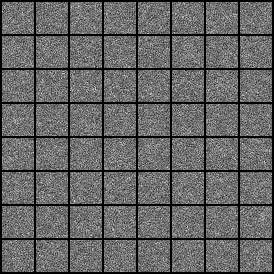

In [27]:
def one_step_sampling(model, bs, scale=1000):
    e = torch.randn(bs, 1, 32, 32).cuda()
    sample = model(e, torch.tensor([1.0]*bs,).cuda(), torch.tensor([1.0]*bs,).cuda())[0]
    x = e +sample 
    return x 

x = one_step_sampling(model, 64)
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(x.detach().cpu(), nrow=8, normalize=True))

## Multistep sampling. 

In [28]:
r = torch.arange(0, 1000+(1000//200), 1000//200)
rt = torch.stack([r[:-1], r[1:]]).permute(1, 0)
rt.shape

torch.Size([200, 2])

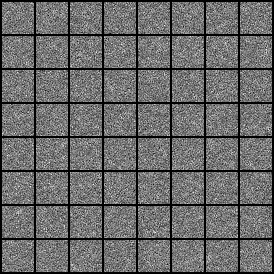

In [ ]:
def multi_step_sampling(model, bs, n_steps, scale=1000):
    e = torch.randn(bs, 1, 32, 32).to(model.device)
    _scale = 1000
    r = torch.arange(0, _scale+(_scale//n_steps), _scale//n_steps).to(model.device)/_scale
    rt = torch.stack([r[:-1], r[1:]]).permute(1, 0)
    for i in range(n_steps):
        _rt = rt[i]
        r, t = _rt
        t_r = t - r 
        with torch.no_grad():
            sample = model(e, torch.tensor([t]).to(model.device), torch.tensor([t_r]).to(model.device))[0]
        e = e + (t_r)*sample 
    return e 

x = multi_step_sampling(model, 64, 10, scale=1)
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(x.detach().cpu(), nrow=8, normalize=True))

## Full training pipeline 

In the paper they found the following parameters to work and gave the best FID score.
- 25% of the training loop r is not equal to t. this means that it drops down to simple Flow matching 
- t and r comes from lognorm(-2, 2). In paper this is little confusion to me whether it is logit norm or LogNorm. I will go with logitnorm. 
- used Pseudo-Huber loss and the got the best FID score for p=1.5 
- jvp used is (v, 0, 1).
- instead of (r, t), (t, t-r) gave the best results though the changes are minimal. so we will continue using (r, t)
- CFG scale: we will skip this for now. 

In [30]:
norm = torch.distributions.Normal(loc=-2, scale=1)
rt = torch.sigmoid(norm.sample((bs,2))).sort(dim=1).values 
rt.shape

torch.Size([64, 2])

In [31]:
def sample_rt(bs, dist, p=0.25):
    rt1 = torch.sigmoid(dist.sample((int(bs*p),2))).sort(dim=1).values
    rt2 = torch.sigmoid(dist.sample((int(bs*(1-p)), )))
    rt2 = torch.stack([rt2, rt2]).permute(1, 0)
    rt = torch.cat([rt1, rt2], dim=0)
    #shuffle rows 
    rt = rt[torch.randperm(rt.shape[0])]
    return rt 

In [32]:
sample_rt(16, norm, 0.25)

tensor([[0.0668, 0.2189],
        [0.1190, 0.1957],
        [0.0236, 0.0236],
        [0.1176, 0.1176],
        [0.0871, 0.0975],
        [0.1681, 0.1681],
        [0.1266, 0.1266],
        [0.0897, 0.0897],
        [0.1623, 0.1623],
        [0.0629, 0.0629],
        [0.0951, 0.2154],
        [0.0835, 0.0835],
        [0.4807, 0.4807],
        [0.2609, 0.2609],
        [0.3189, 0.3189],
        [0.0383, 0.0383]])

In [33]:
# we will add EMA weights to the model. 
import copy

def exists(val):
    return val is not None

class EMA():
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
    def update_average(self, old, new):
        if not exists(old):
            return new
        return old * self.beta + (1 - self.beta) * new

ema = EMA(beta=0.99995)
ema_model = copy.deepcopy(model)

In [34]:
import fastcore.all as fc 
storage_path = fc.Path("mean_flow_weights")
storage_path.mkdir(parents=True, exist_ok=True)

In [35]:
epochs = 100 
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-5)
train_loader, val_loader = load_mnist(bs=128)
total_steps = len(train_loader) * epochs
tdist = torch.distributions.Normal(-2, 2)
partial_model = partial(model, return_dict=False)
scale =1 

iter = 0 
train_loss = []

for epoch in range(epochs):
    model.train()
    epoch_loss = []
    with tqdm(train_loader, unit="batch") as tepoch:
        for batch in tepoch:
            optimizer.zero_grad()
            
            x1, _ = batch
            bs = x1.shape[0]
            x1 = x1.to(device)
            noise = torch.randn((bs, 1, 32, 32), device=device)
            target = x1 - noise 
            rt = sample_rt(bs, tdist, 0.75)
            t = rt[:, 1].unsqueeze(1).unsqueeze(1).unsqueeze(1).to(device)
            xt = t*x1 + (1-t)*noise

            

            u, dudt = torch.autograd.functional.jvp(
                partial_model, 
                (xt.to(device), (rt[:, 0]*scale).to(device), ((rt[:, 1]-rt[:, 0])*scale).to(device)), 
                (target.to(device), torch.zeros(bs).to(device), torch.ones(bs).to(device)),
                create_graph=True
            )
            u, dudt = u[0], dudt[0]
            u_tgt = target.to(device) - (rt[:, 1] - rt[:, 0]).unsqueeze(1).unsqueeze(1).unsqueeze(1).to(device)*dudt
            u_tgt_detached = u_tgt.detach()
            u_tgt_detached = torch.clamp(u_tgt_detached, target.min(), target.max())
            #loss = torch.nn.functional.mse_loss(u, u_tgt_detached)
            #loss = adaptive_weighted_short(u, u_tgt_detached, p=1.0)
            loss = adaptive_l2_loss(u - u_tgt_detached)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Add gradient clipping
            optimizer.step()

            #calculate loss 
            tepoch.set_postfix(loss=loss.item())
            epoch_loss.append(loss.item())
                    
            #update ema model 
            for current_params, ma_params in zip(model.parameters(), model.parameters()):
                    old_weight, up_weight = ma_params.data, current_params.data
                    ma_params.data = ema.update_average(old_weight, up_weight)
    
    train_loss.extend(epoch_loss)
    store = {
         "ema_model": ema_model.state_dict(),
         "model": model.state_dict(),
         "train_loss": np.mean(epoch_loss)
    }
    torch.save(store, storage_path/f"ema_model_{epoch}_{np.mean(epoch_loss):3f}.pth")
    print(f"Epoch {epoch} completed: train loss {np.mean(epoch_loss)}")
    #TODO: calculate some metric between generated images and original images

    ema_model.eval()
    out= one_step_sampling(ema_model, 64, scale=scale)
    img = torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(out.cpu(), nrow=8, normalize=True))
    img.save(storage_path/f"generated_images_one_step_{epoch}.png")

    out= multi_step_sampling(ema_model, 64, 20, scale=scale)
    img = torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(out.cpu(), nrow=8, normalize=True))
    img.save(storage_path/f"generated_images_multi_step_{epoch}.png")
    torch.cuda.empty_cache()
        
    

  0%|          | 0/469 [00:00<?, ?batch/s]

100%|██████████| 469/469 [03:08<00:00,  2.48batch/s, loss=0.549]


Epoch 0 completed: train loss 0.579037220239131


100%|██████████| 469/469 [03:09<00:00,  2.47batch/s, loss=0.492]


Epoch 1 completed: train loss 0.5154155427331863


 55%|█████▍    | 256/469 [01:43<01:25,  2.48batch/s, loss=0.472]


KeyboardInterrupt: 

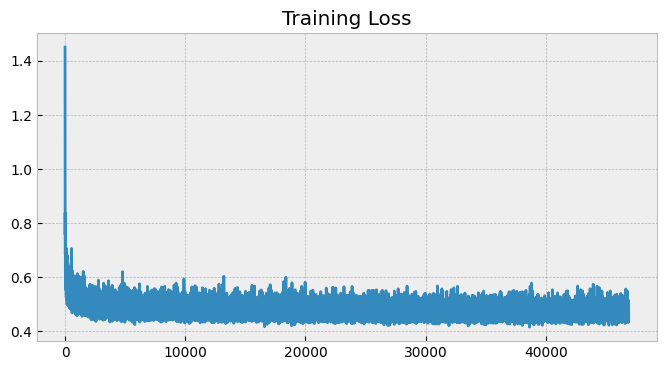

In [104]:
plt.figure(figsize=(8, 4))
plt.plot(train_loss)
plt.title("Training Loss")
plt.show()

## inference 

In [100]:
model = load_model(device, channels=1)
weights = torch.load("mean_flow/ema_model_99_0.471887.pth", weights_only=False)
model.load_state_dict(weights["ema_model"])
model.eval()
print("loaded weights and set in eval mode")

loaded weights and set in eval mode


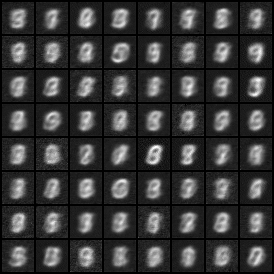

In [103]:
bs = 64
scale = 1
e = torch.randn(bs, 1, 32, 32).cuda()
sample = model(e, torch.tensor([[0.0, 1.0*scale]]*bs).cuda())
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(e+sample, nrow=8, normalize=True))